# Functional connectiviy Template 
### (Classifier)
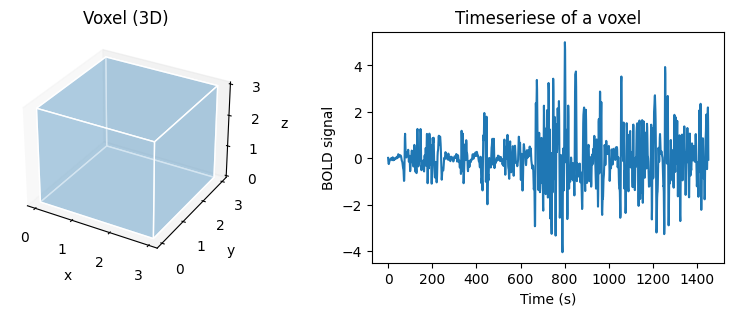

In [1]:
# Import necessary libraries
import os
import json
import numpy as np
import pandas as pd
import seaborn as sns
from glob import glob
from pathlib import Path
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import matplotlib.patches as mpatches
from matplotlib import colormaps, colors
from nilearn import datasets, maskers, plotting
from nilearn.maskers import NiftiLabelsMasker
from nilearn.connectome import ConnectivityMeasure


# Ignore warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

In [2]:
pip install --quiet optuna-integration

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install --quiet pytorch-ranger

Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install --quiet --upgrade torch torchvision

Note: you may need to restart the kernel to use updated packages.


In [5]:
# Deep Learning libraries
import torch
import optuna
import torch.nn as nn
import torch.optim as optim
from pytorch_ranger import Ranger
from sklearn import metrics
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc
from optuna.integration import PyTorchLightningPruningCallback

# Device selection: DirectML or fallback to CUDA/CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


## **Load and explore the data**

### Target Variable ( Y )

In [6]:
csv_path = '/kaggle/input/pixar/pixar_pheno.csv'

pheno = pd.read_csv(csv_path)

In [7]:
# INFO

# Display the shape of the data
print("Data Shape:")
print(pheno.shape)

# Check for any duplicate entries in the data.
print('')
print("Duplicate Values:")
print('(',pheno.duplicated().sum(),')')


# Display the data types of the columns
print("\nData Types:")
print(pheno.dtypes.value_counts())

# Check for missing values
missing_columns = pheno.columns[pheno.isnull().any()]
if missing_columns.size > 0:
    missing_values = pheno[missing_columns].isnull().sum()
    missing_percentage = (missing_values / len(pheno)) * 100

    # Combine missing_values and missing_percentage into a single DataFrame
    missing_data = pd.concat([missing_values, missing_percentage], axis=1, keys=['Total', 'Percent'])

    # Sort the missing_data DataFrame by Total column in descending order
    missing_data = missing_data.sort_values(by='Total', ascending=False)

    # Print missing data
    print("\nMissing Data:")
    print(missing_data.to_string())
else:
    print("\nNo Missing Values Found")



Data Shape:
(155, 6)

Duplicate Values:
( 0 )

Data Types:
object     5
float64    1
Name: count, dtype: int64

No Missing Values Found


Number of classes: ['F' 'M']
Gender
F    84
M    71
Name: count, dtype: int64


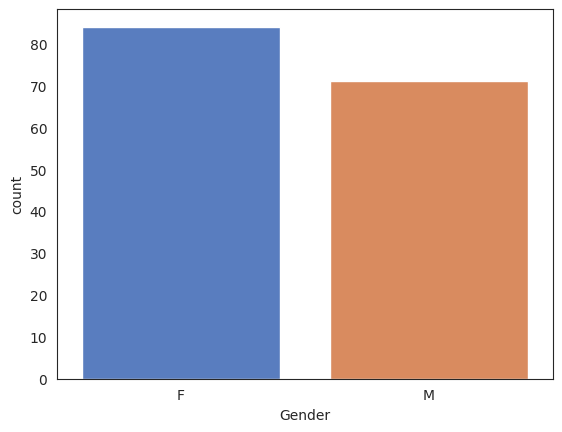

In [8]:
sex = pheno['Gender']

print('Number of classes:',sex.unique())

sns.set_style("white")
sns.set_palette("muted")
sns.countplot(x= sex)

print(sex.value_counts())

**AGE DISTRIBUTION**

Asymmetry: 1.544492
Kurtosis: 1.425876


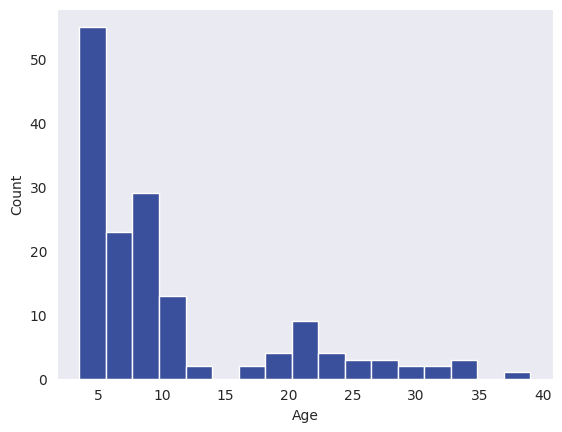

In [9]:
age = pheno['Age']

sns.set_style("dark")
sns.set_palette("dark")
sns.histplot(age)

#skewness and kurtosis
print("Asymmetry: %f" % age.skew())
print("Kurtosis: %f" % age.kurt())

In [10]:
# Group by column
diagnosis = pheno.groupby('Child_Adult')

# Calculate descriptive statistics
diagnosis['Age'].describe()

,count,mean,std,min,25%,50%,75%,max
Child_Adult,,,,,,,,
adult,33.0,24.772727,5.308521,18.000000,21.00000,23.00,28.0000,39.0
child,122.0,6.709461,2.330938,3.518138,4.89521,5.98,8.3975,12.3


### Independent Variables ( x )

In [11]:
# Load the features 

feat_file = '/kaggle/input/pixar/pixar_features.npz' 
X_features = np.load(feat_file)['a']

print('Features shape:', X_features.shape)

Features shape: (155, 2016)


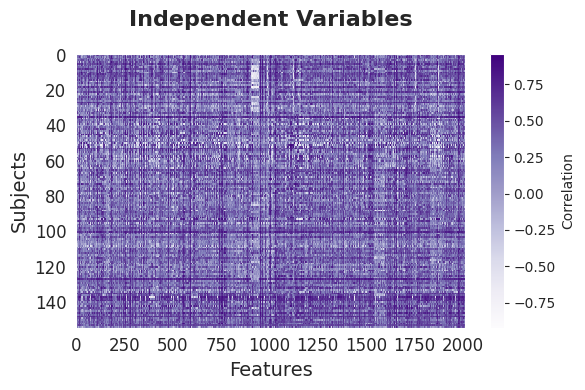

In [12]:
# Independent Variables

def plot_feature_matrix(X_features, title='Independent Variables', xlabel='Features', ylabel='Subjects'):

    plt.figure(figsize=(6, 4))  # Increased size for better visibility
    plt.imshow(X_features, aspect='auto', cmap='Purples', interpolation='nearest')  # Changed colormap to 'plasma'

    # Add colorbar
    cbar = plt.colorbar(label='Correlation')
    cbar.ax.tick_params(labelsize=10)  # Colorbar ticks

    # Add title and labels with enhanced aesthetics
    plt.title(title, fontsize=16, fontweight='bold', pad=20)  # Larger, bold title
    plt.xlabel(xlabel, fontsize=14)
    plt.ylabel(ylabel, fontsize=14)

    # Improve ticks
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)

    # Add gridlines for better readability
    plt.grid(False)  # Set to True for actual gridlines, adjust as necessary

    # Tight layout
    plt.tight_layout()
    plt.show()


plot_feature_matrix(X_features)

 ### **Probabilistic Atlas**


In [13]:
dim = 64
difumo = datasets.fetch_atlas_difumo(
    dimension=dim, resolution_mm=2, legacy_format=False
)

atlas_filename = difumo.maps



Added README.md to /root/nilearn_data


Dataset created in /root/nilearn_data/difumo_atlases



 ...done. (2 seconds, 0 min)
Extracting data from /root/nilearn_data/difumo_atlases/0fd53859aa9fed124e741c85ec45c705/download..... done.


 ...done. (2 seconds, 0 min)


In [14]:
# Label mapping for the Atlas
labels = difumo.labels["difumo_names"]
feature_names = [f'{labels[i]} - {labels[j]}' for i in range(dim) for j in range(i + 1, dim)]
feature_indices = list(range(1, len(feature_names) + 1))

# Create a DataFrame
feature_mapping_df = pd.DataFrame({
    'Feature Index': feature_indices,
    'Feature Name': feature_names
})

# Display a sample of the feature mapping DataFrame
print(feature_mapping_df.head(5))


   Feature Index                                       Feature Name
0              1           Superior frontal sulcus - Fusiform gyrus
1              2  Superior frontal sulcus - Calcarine cortex pos...
2              3  Superior frontal sulcus - Cingulate cortex pos...
3              4  Superior frontal sulcus - Parieto-occipital su...
4              5   Superior frontal sulcus - Insula antero-superior


## **Prepare data for machine learning**

In [15]:
from sklearn.preprocessing import LabelEncoder

# Initialize LabelEncoder
label_encoder = LabelEncoder()
y_target = label_encoder.fit_transform(pheno['Gender'])

# Print label encoding mapping
print("Label Encoding Mapping:")
for label, encoding in zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)):
    print(f"{label}: {encoding}")


Label Encoding Mapping:
F: 0
M: 1


In [16]:
# Separate features and target
y = y_target
x = X_features


x = torch.tensor(x, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32).view(-1, 1)

In [17]:
# Constants
BATCH_SIZE = 32
TEST_SIZE = 0.25
RANDOM_STATE = 42

# Split into train/test sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y.numpy())

# Move data to the appropriate device (DirectML, CUDA, or CPU)
x_train, y_train, x_test, y_test = [t.to(device) for t in [x_train, y_train, x_test, y_test]]

# DataLoader creation
train_dataset = TensorDataset(x_train, y_train)
test_dataset = TensorDataset(x_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

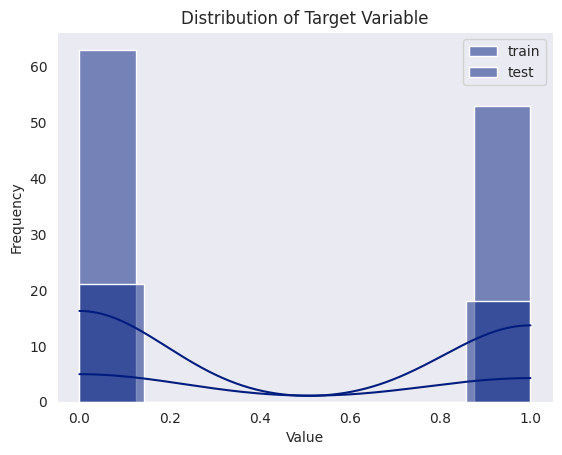

training: 116 testing: 39


In [18]:
#import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming `device` is already defined and is a torch.device object
# Convert tensors to NumPy arrays by first moving them to CPU
y_train_cpu = y_train.cpu().numpy()
y_test_cpu = y_test.cpu().numpy()
X_train_cpu = x_train.cpu().numpy()
X_test_cpu = x_test.cpu().numpy()

# Plot histograms
sns.histplot(y_train_cpu, label='train', kde=True)
sns.histplot(y_test_cpu, label='test', kde=True)
plt.legend()
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Distribution of Target Variable')
plt.show()

# Print the size of the training and test sets
print('training:', len(x_train), 'testing:', len(x_test))



### **Label mapping for the Atlas**

In [19]:
import pandas as pd

# Assuming labels is defined somewhere as difumo.labels["difumo_names"]

# Generate feature names and indices
labels = difumo.labels["difumo_names"]
feature_names = [f'{labels[i]} - {labels[j]}' for i in range(dim) for j in range(i + 1, dim)]
feature_indices = list(range(1, len(feature_names) + 1))

# Create a DataFrame
feature_mapping_df = pd.DataFrame({
    'Feature Index': feature_indices,
    'Feature Name': feature_names
})

# Display a sample of the feature mapping DataFrame
print(feature_mapping_df.head(5))


   Feature Index                                       Feature Name
0              1           Superior frontal sulcus - Fusiform gyrus
1              2  Superior frontal sulcus - Calcarine cortex pos...
2              3  Superior frontal sulcus - Cingulate cortex pos...
3              4  Superior frontal sulcus - Parieto-occipital su...
4              5   Superior frontal sulcus - Insula antero-superior


# **Deep Learning**

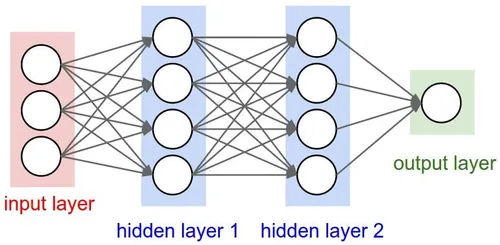

## **Run the Classification Model**

In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
import optuna
import numpy as np
from sklearn.metrics import accuracy_score, roc_auc_score
from torch.utils.data import DataLoader

# Classification Model Definition
class ClassificationModel(nn.Module):
    def __init__(self, input_dim, hidden_layers, dropout_rate, activation_fn, weight_init):
        super(ClassificationModel, self).__init__()
        layers = []
        last_dim = input_dim

        # Hidden layers
        for hidden_dim in hidden_layers:
            layers.append(nn.Linear(last_dim, hidden_dim))
            layers.append(nn.BatchNorm1d(hidden_dim))
            
            # Activation function
            if activation_fn == 'mish':
                layers.append(nn.Mish())
            elif activation_fn == 'leaky_relu':
                layers.append(nn.LeakyReLU())

            layers.append(nn.Dropout(dropout_rate))
            last_dim = hidden_dim

        # Output layer (Binary classification)
        layers.append(nn.Linear(last_dim, 1))

        # Optionally apply weight initialization
        self.apply(weight_init)

        # Sigmoid activation for binary classification
        layers.append(nn.Sigmoid())
        
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

# Define different weight initialization strategies
def weight_init(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        nn.init.zeros_(m.bias)

# Hyperparameter Optimization Function using Optuna
def objective(trial):
    # Suggest hyperparameters
    hidden_layers = trial.suggest_categorical('hidden_layers', [[256, 128], [512, 256, 128], [512, 256]])
    dropout_rate = trial.suggest_float('dropout_rate', 0.0, 0.3)
    lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
    weight_decay = trial.suggest_loguniform('weight_decay', 1e-6, 1e-3)
    batch_size = trial.suggest_categorical('batch_size', [32, 64, 128])
    patience = trial.suggest_int('patience', 15, 20)
    activation_fn = trial.suggest_categorical('activation_fn', ['mish','leaky_relu'])
    optimizer_name = trial.suggest_categorical('optimizer', ['AdamW','Ranger'])
    scheduler_name = trial.suggest_categorical('scheduler', ['CosineAnnealingLR', 'StepLR', 'ReduceLROnPlateau'])
    clip_grad = trial.suggest_float('clip_grad', 0.5, 5.0)  # Clip gradients between 0.5 and 5.0

    # Model initialization
    model = ClassificationModel(input_dim=x_train.shape[1], hidden_layers=hidden_layers,
                                dropout_rate=dropout_rate, activation_fn=activation_fn, weight_init=weight_init).to(device)

    # Optimizer selection
    if optimizer_name == 'AdamW':
        optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    elif optimizer_name == 'Ranger':
        optimizer = Ranger(model.parameters(), lr=lr, weight_decay=weight_decay)

    # Loss function: Experiment with BCEWithLogitsLoss for better numerical stability
    criterion = nn.BCEWithLogitsLoss()

    # Scheduler selection
    if scheduler_name == 'CosineAnnealingLR':
        scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=MAX_EPOCHS)
    elif scheduler_name == 'StepLR':
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
    elif scheduler_name == 'ReduceLROnPlateau':
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.1)

    # DataLoader with updated batch size
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Training loop with early stopping
    best_loss = float('inf')
    no_improvement = 0

    for epoch in range(MAX_EPOCHS):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()

            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), clip_grad)

            optimizer.step()
            running_loss += loss.item()

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                val_loss += criterion(outputs, labels).item()

        val_loss /= len(test_loader)
        scheduler.step(val_loss) if scheduler_name == 'ReduceLROnPlateau' else scheduler.step()

        # Early stopping
        if val_loss < best_loss - 1e-3:
            best_loss = val_loss
            no_improvement = 0
        else:
            no_improvement += 1

        if no_improvement >= patience:
            break

    return val_loss



## **Best Hyperparameters**

In [21]:
# Hyperparameter Optimization 
MAX_EPOCHS = 1000  # Define maximum epochs

# Set the level
optuna.logging.set_verbosity(optuna.logging.WARNING)
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=200)  # Conduct trials for optimization

# Retrieve the best hyperparameters
best_params = study.best_params
print(f"Best hyperparameters: {best_params}")

Best hyperparameters: {'hidden_layers': [512, 256], 'dropout_rate': 0.16620180281040167, 'lr': 0.0018839880691430958, 'weight_decay': 1.614877946002688e-06, 'batch_size': 32, 'patience': 16, 'activation_fn': 'mish', 'optimizer': 'Ranger', 'scheduler': 'CosineAnnealingLR', 'clip_grad': 3.339693712238086}


In [22]:
# Model Training Function
def train_model(model, train_loader, test_loader, criterion, optimizer, scheduler, max_epochs, patience, clip_grad=None, scheduler_name=None):
    best_loss = float('inf')
    no_improvement = 0

    for epoch in range(max_epochs):
        model.train()
        running_loss = 0.0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            # Backward pass and optimization
            loss.backward()

            # Gradient clipping
            if clip_grad is not None:
                torch.nn.utils.clip_grad_norm_(model.parameters(), clip_grad)

            optimizer.step()
            running_loss += loss.item()

        model.eval()
        val_loss = 0.0

        # Validation step
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                val_loss += criterion(outputs, labels).item()

        val_loss /= len(test_loader)
        running_loss /= len(train_loader)

        print(f"Epoch [{epoch+1}/{max_epochs}], Train Loss: {running_loss:.4f}, Val Loss: {val_loss:.4f}")

        # Update scheduler (if using ReduceLROnPlateau)
        if scheduler_name == 'ReduceLROnPlateau':
            scheduler.step(val_loss)
        else:
            scheduler.step()

        # Early stopping
        if val_loss < best_loss - 1e-3:
            best_loss = val_loss
            no_improvement = 0
        else:
            no_improvement += 1
        
        if no_improvement >= patience:
            print("Early stopping triggered")
            break

    return model

# Model Evaluation Function
def evaluate_model(model, test_loader):
    model.eval()
    all_outputs, all_labels = [], []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            all_outputs.append(outputs.cpu().numpy())
            all_labels.append(labels.cpu().numpy())

    all_outputs = np.concatenate(all_outputs)
    all_labels = np.concatenate(all_labels)

    # Calculate evaluation metrics
    auc_roc = roc_auc_score(all_labels, all_outputs)
    accuracy = accuracy_score(all_labels, np.round(all_outputs))
    return auc_roc, accuracy

# Initialize Model with the Best Hyperparameters
hidden_layers = best_params['hidden_layers']
dropout_rate = best_params['dropout_rate']
activation_fn = best_params['activation_fn']
lr = best_params['lr']
weight_decay = best_params['weight_decay']
optimizer_name = best_params['optimizer']
scheduler_name = best_params['scheduler']
clip_grad = best_params.get('clip_grad', None)  # Gradient clipping value if provided

model = ClassificationModel(input_dim=x_train.shape[1], hidden_layers=hidden_layers,
                            dropout_rate=dropout_rate, activation_fn=activation_fn, weight_init=weight_init).to(device)

# Select Optimizer
if optimizer_name == 'AdamW':
        optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
elif optimizer_name == 'Ranger':
        optimizer = Ranger(model.parameters(), lr=lr, weight_decay=weight_decay)

# Loss Function
criterion = nn.BCEWithLogitsLoss()

# Select Scheduler
if scheduler_name == 'CosineAnnealingLR':
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=MAX_EPOCHS)
elif scheduler_name == 'StepLR':
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
elif scheduler_name == 'ReduceLROnPlateau':
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.1)



## **Train the Model**

In [23]:
# Train the Model
train_loader = DataLoader(train_dataset, batch_size=best_params['batch_size'], shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=best_params['batch_size'], shuffle=False)
trained_model = train_model(model, train_loader, test_loader, criterion, optimizer, scheduler, max_epochs=MAX_EPOCHS, patience=best_params['patience'], clip_grad=clip_grad, scheduler_name=scheduler_name)


Epoch [1/1000], Train Loss: 0.7414, Val Loss: 0.7216
Epoch [2/1000], Train Loss: 0.7388, Val Loss: 0.7194
Epoch [3/1000], Train Loss: 0.7143, Val Loss: 0.7178
Epoch [4/1000], Train Loss: 0.7029, Val Loss: 0.7156
Epoch [5/1000], Train Loss: 0.6868, Val Loss: 0.7151
Epoch [6/1000], Train Loss: 0.6577, Val Loss: 0.7157
Epoch [7/1000], Train Loss: 0.6510, Val Loss: 0.7168
Epoch [8/1000], Train Loss: 0.6325, Val Loss: 0.7111
Epoch [9/1000], Train Loss: 0.6260, Val Loss: 0.7069
Epoch [10/1000], Train Loss: 0.6079, Val Loss: 0.6933
Epoch [11/1000], Train Loss: 0.6056, Val Loss: 0.6877
Epoch [12/1000], Train Loss: 0.5829, Val Loss: 0.6864
Epoch [13/1000], Train Loss: 0.5936, Val Loss: 0.6945
Epoch [14/1000], Train Loss: 0.5724, Val Loss: 0.6755
Epoch [15/1000], Train Loss: 0.5612, Val Loss: 0.6757
Epoch [16/1000], Train Loss: 0.5539, Val Loss: 0.6613
Epoch [17/1000], Train Loss: 0.5508, Val Loss: 0.6612
Epoch [18/1000], Train Loss: 0.5513, Val Loss: 0.6646
Epoch [19/1000], Train Loss: 0.5438, 

In [24]:
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score

# Model Evaluation Function
def evaluate_model(model, test_loader):
    model.eval()
    all_outputs, all_labels = [], []
    
    # Inference loop
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            all_outputs.append(outputs.cpu().numpy())
            all_labels.append(labels.cpu().numpy())

    # Concatenate results
    all_outputs = np.concatenate(all_outputs)
    all_labels = np.concatenate(all_labels)

    # Threshold the outputs (since it's binary classification)
    predicted_labels = np.round(all_outputs)

    # Calculate evaluation metrics
    auc_roc = roc_auc_score(all_labels, all_outputs)  # AUC-ROC
    accuracy = accuracy_score(all_labels, predicted_labels)  # Accuracy
    precision = precision_score(all_labels, predicted_labels)  # Precision
    recall = recall_score(all_labels, predicted_labels)  # Recall
    f1 = f1_score(all_labels, predicted_labels)  # F1-score

    # Print metrics
    print(f"AUC-ROC: {auc_roc:.4f}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")

    return auc_roc, accuracy, precision, recall, f1


## **Evaluate the trained model**

In [25]:
# Evaluate the trained model on the test dataset
auc_roc, accuracy, precision, recall, f1 = evaluate_model(trained_model, test_loader)


AUC-ROC: 0.7275
Accuracy: 0.7179
Precision: 0.7333
Recall: 0.6111
F1-Score: 0.6667


In [26]:
# Save the model's state dict
torch.save(trained_model.state_dict(), 'Pytorch_Classifier_fMRI.pth')


In [27]:
import json

# Save hyperparameters
with open('Pytorch_Classifier_fMRI_hyperparameters.json', 'w') as f:
    json.dump(best_params, f)


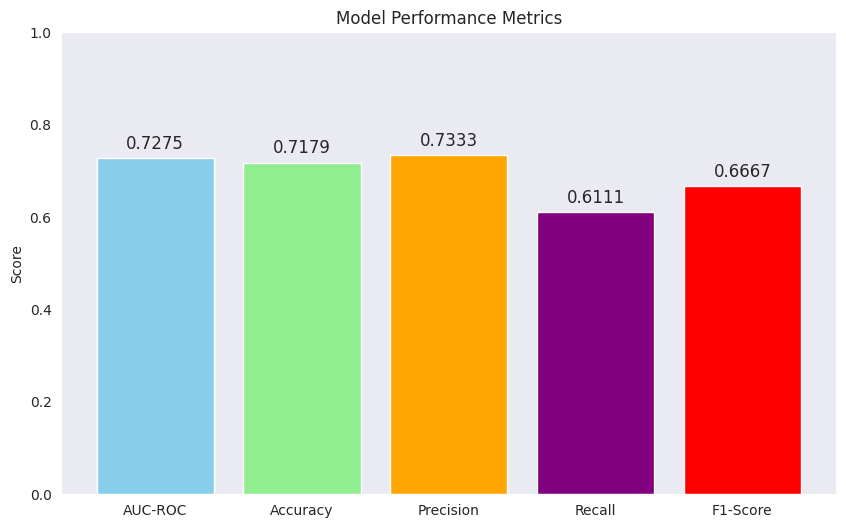

In [28]:
metrics = {'AUC-ROC': auc_roc, 'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'F1-Score': f1}
metric_names = list(metrics.keys())
metric_values = list(metrics.values())

plt.figure(figsize=(10, 6))
plt.bar(metric_names, metric_values, color=['skyblue', 'lightgreen', 'orange', 'purple', 'red'])
plt.title("Model Performance Metrics")
plt.ylabel("Score")
plt.ylim(0, 1)  # As all scores are in [0, 1]
for i, v in enumerate(metric_values):
    plt.text(i, v + 0.02, f"{v:.4f}", ha='center', fontsize=12)
plt.show()

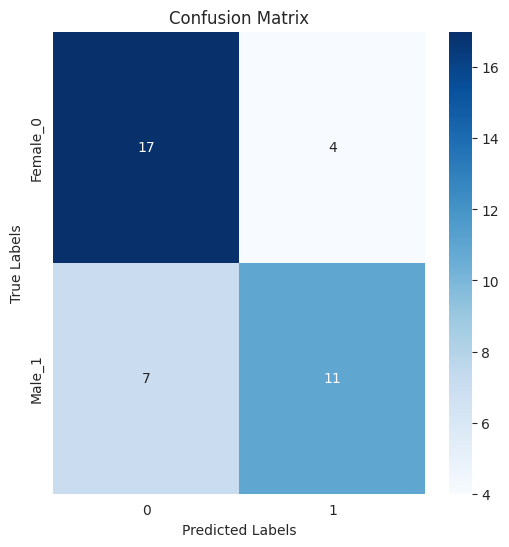

In [29]:
from sklearn.metrics import confusion_matrix


# 2. Confusion Matrix
# Get model predictions and true labels
all_outputs = []
all_labels = []
trained_model.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = trained_model(inputs)
        all_outputs.append(outputs.cpu().numpy())
        all_labels.append(labels.cpu().numpy())

all_outputs = np.concatenate(all_outputs)
all_labels = np.concatenate(all_labels)

# Convert probabilities to binary predictions (0 or 1)
predictions = np.round(all_outputs)

# Confusion Matrix
conf_matrix = confusion_matrix(all_labels, predictions)

# Plot Confusion Matrix
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['0', '1'], 
            yticklabels=['Female_0', 'Male_1'])
plt.title('Confusion Matrix')
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')
plt.show()

### **Feature Importance Analysis**

In [30]:
# Feature importance
def perturbation_rank(model, x_test, y_test, feature_names, verbose=False):
    model.eval()
    baseline_loss = criterion(model(x_test), y_test).item()
    importance_scores = []

    for i in range(x_test.shape[1]):
        x_test_perturbed = x_test.clone()
        x_test_perturbed[:, i] = x_test_perturbed[torch.randperm(x_test_perturbed.size(0)), i]
        perturbed_loss = criterion(model(x_test_perturbed), y_test).item()
        importance = perturbed_loss - baseline_loss
        importance_scores.append(importance)

        if verbose:
            print(f"Feature {feature_names[i]} - Perturbed Loss: {perturbed_loss:.4f} - Importance: {importance:.4f}")

    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importance_scores
    }).sort_values(by='Importance', ascending=False).reset_index(drop=True)

    return importance_df


# Feature Importance
feature_names = feature_mapping_df['Feature Name'].tolist()
rois_rank = perturbation_rank(trained_model, x_test, y_test, feature_names)

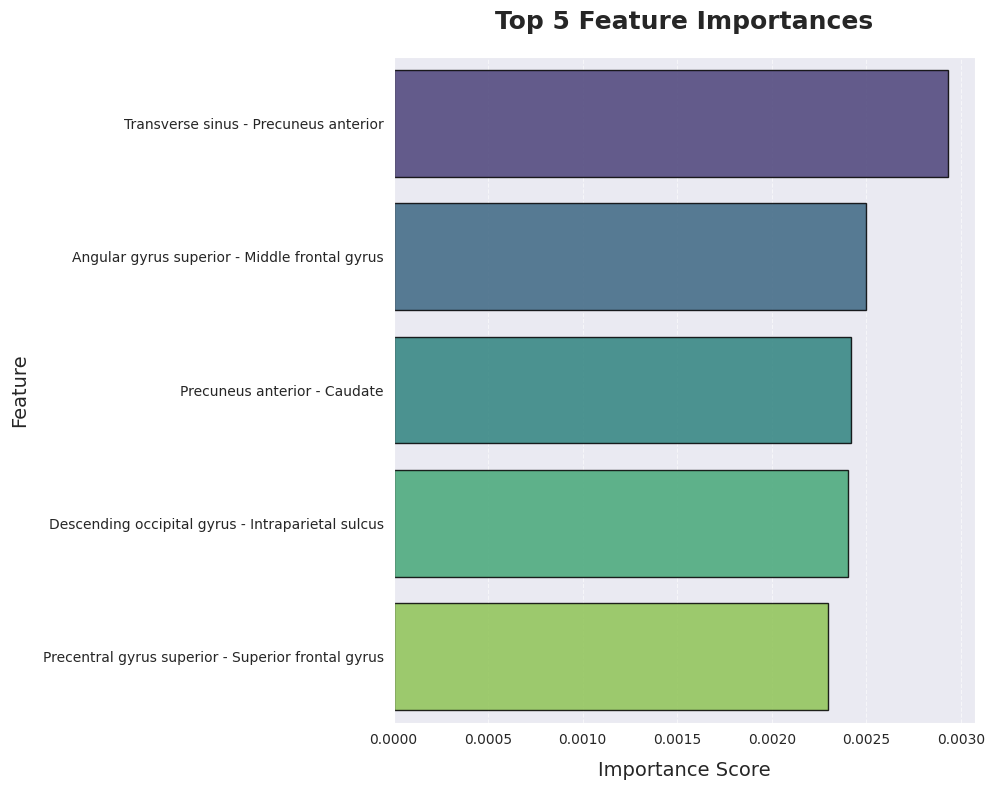

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_top_features(top_features, title="Top 5 Feature Importances"):

    plt.figure(figsize=(10, 8))
    
    # Use a custom color palette
    custom_palette = sns.color_palette("viridis", len(top_features))
    
    # Create the barplot
    sns.barplot(x='Importance', y='Feature', data=top_features, palette=custom_palette, edgecolor='black', alpha=0.85)

    # Customize the title and labels
    plt.title(title, fontsize=18, fontweight='bold', pad=20)
    plt.xlabel('Importance Score', fontsize=14, labelpad=10)
    plt.ylabel('Feature', fontsize=14, labelpad=10)


    # Add subtle gridlines
    plt.grid(True, axis='x', linestyle='--', alpha=0.6)

    # Tweak the layout
    plt.tight_layout()

    # Show the plot
    plt.show()

# Example usage
top_5_feature_importances = rois_rank.head(5)
plot_top_features(top_5_feature_importances)


### Visualize Regions of Interest

In [32]:
difumo_labels = difumo.labels
marker_labels = difumo_labels['difumo_names'].tolist() 

# grab center coordinates for probabilistic atlas
coords = plotting.find_probabilistic_atlas_cut_coords(
    maps_img=difumo.maps)

**Functions**

In [33]:
# Import Delaunay for triangulation
from scipy.spatial import Delaunay  

def pink_crystal_connectome(df, coords, marker_labels, cmap_markers='viridis', cmap_edges='Paired'):
    """
    Visualizes a connectome on a fixed 3D surface using Plotly.
    
    Parameters:
    - df: DataFrame containing correlations between markers.
    - coords: Array of coordinates for the markers.
    - marker_labels: Labels for the markers.
    - cmap_markers: Colormap for the marker colors.
    - cmap_edges: Colormap for the edge colors.
    """

    vertices = coords  # Use the given coordinates for the surface

    # Create a Plotly figure
    fig = go.Figure()

    # Normalize correlations for color mapping
    norm = colors.Normalize(vmin=df['Importance'].min(), vmax=df['Importance'].max())
    cmap_markers = plt.colormaps[cmap_markers]
    cmap_edges = plt.colormaps[cmap_edges]

    # Triangulate the surface mesh using Delaunay triangulation
    if vertices.shape[0] >= 3:  # Ensure we have enough points to form a surface
        tri = Delaunay(vertices[:, :2])  # Use only the x and y coordinates for triangulation

        fig.add_trace(go.Mesh3d(
            x=vertices[:, 0],
            y=vertices[:, 1],
            z=vertices[:, 2],
            color='lightcoral',  # Light color for the surface
            opacity=0.05,  # Adjust opacity for visibility (lower for more transparency)
            i=tri.simplices[:, 0],
            j=tri.simplices[:, 1],
            k=tri.simplices[:, 2],
            name='Brain Surface',  # Name for legend
            showlegend=True  # Show in legend
        ))

    # Ensure marker_labels is a list
    if isinstance(marker_labels, pd.Index):
        marker_labels = marker_labels.tolist()

    # Extract unique markers from the top rows
    unique_markers = pd.unique(df[['Marker1', 'Marker2']].values.ravel('K'))

    # Filter marker labels and coordinates to only include those in unique_markers
    filtered_indices = [i for i, label in enumerate(marker_labels) if label in unique_markers]
    filtered_coords = coords[filtered_indices]
    filtered_labels = [marker_labels[i] for i in filtered_indices]

    # Add nodes to the plot
    fig.add_trace(go.Scatter3d(
        x=filtered_coords[:, 0],
        y=filtered_coords[:, 1],
        z=filtered_coords[:, 2],
        mode='markers+text',
        marker=dict(size=8, color=[colors.to_hex(cmap_markers(norm(c))) for c in df['Importance']]),
        text=filtered_labels,
        textfont=dict(color='black', size=13, family="Arial"),  # Changed text color to black
        textposition='middle right',
        name='Markers'
    ))

    # Add edges to the plot
    for i, row in df.iterrows():
        marker1 = row['Marker1']
        marker2 = row['Marker2']
        correlation = row['Importance']

        marker1_idx = filtered_labels.index(marker1)
        marker2_idx = filtered_labels.index(marker2)

        fig.add_trace(go.Scatter3d(
            x=[filtered_coords[marker1_idx, 0], filtered_coords[marker2_idx, 0]],
            y=[filtered_coords[marker1_idx, 1], filtered_coords[marker2_idx, 1]],
            z=[filtered_coords[marker1_idx, 2], filtered_coords[marker2_idx, 2]],
            mode='lines',
            line=dict(color=colors.to_hex(cmap_edges(norm(correlation))), width=3),
            name=f"{marker1} - {marker2} ({correlation:.2f})"
        ))

    # Update layout
    fig.update_layout(
        title=dict(
            text='',
            x=0.5,
            y=0.95,
            font=dict(size=22, color='navy', family="Roboto", weight='bold')  # Changed title color to navy blue
        ),
        paper_bgcolor='white',  # Changed background to white
        plot_bgcolor='white',   # Changed plot background to white
        scene=dict(
            xaxis=dict(
                title=dict(text='', font=dict(size=18, color='navy')),  # Changed axes title color to navy
                showbackground=False,
                showgrid=False,  # Disable grid
                showline=False,
                linecolor='navy',  # Change axis line color to navy
                showticklabels=False,
                zeroline=False
            ),
            yaxis=dict(
                title=dict(text='', font=dict(size=18, color='navy')),  # Changed axes title color to navy
                showbackground=False,
                showgrid=False,  # Disable grid
                showline=False,
                linecolor='navy',  # Change axis line color to navy
                showticklabels=False,
                zeroline=False
            ),
            zaxis=dict(
                title=dict(text='', font=dict(size=18, color='navy')),  # Changed axes title color to navy
                showbackground=False,
                showgrid=False,  # Disable grid
                showline=False,
                linecolor='navy',  # Change axis line color to navy
                showticklabels=False,
                zeroline=False
            )
        ),
        margin=dict(
            l=20,
            r=20,
            b=20,
            t=20
        ),
        width=800,
        height=600,
        showlegend=True,
        legend=dict(
            x=0.0,
            y=-0.2,
            font=dict(size=10, color='navy', family="Arial"),  # Changed legend text color to navy
            bgcolor='rgba(255, 255, 255, 0)',  # Changed legend background to transparent
        )
    )
    
    if fig:
        fig.write_html('connectome_plot.html')
        print("Plot successfully saved as 'connectome_plot.html'")
    else:
        print("No figure returned.")
        
    # Show the plot
    fig.show()

In [34]:
# Define a function to map rois to markers

def roi_map(df):
# Ensure 'Feature Name' column exists
    if 'Feature' not in df.columns or 'Importance' not in df.columns:
        raise ValueError("Input DataFrame must contain 'Feature Name' and 'Importance Score' columns.")
    
    # Split `Feature Name` into `Marker1` and `Marker2`
    df[['Marker1', 'Marker2']] = df['Feature'].str.split(' - ', n=1, expand=True)
    
    # Drop the 'Feature Name' column
    df = df.drop(columns=['Feature'])
    
    
    return df

In [35]:
ft_importance = roi_map(rois_rank)
ft_importance

,Importance,Marker1,Marker2
0,0.002931,Transverse sinus,Precuneus anterior
1,0.002501,Angular gyrus superior,Middle frontal gyrus
2,0.002420,Precuneus anterior,Caudate
3,0.002406,Descending occipital gyrus,Intraparietal sulcus
4,0.002295,Precentral gyrus superior,Superior frontal gyrus
...,...,...,...
2011,-0.001745,Descending occipital gyrus,Intraparietal sulcus LH
2012,-0.002087,Planum temporale,Superior occipital gyrus
2013,-0.002135,Superior temporal sulcus with angular gyrus,Superior parietal lobule anterior
2014,-0.002239,Insula antero-superior,Middle frontal gyrus anterior


**Crystal Connectome**

In [36]:
pink_crystal_connectome(ft_importance.head(3), coords, marker_labels, cmap_markers='viridis', cmap_edges='Paired')

Plot successfully saved as 'connectome_plot.html'


![alt text](image.png)